In [ ]:
%pip install ipython
from IPython.display import display, Image




[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
from typing import TypedDict, List, Optional, Dict, Annotated
import json # For parsing LLM plan output
import re # For robust JSON extraction
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import MessagesState

from langchain.agents import initialize_agent, AgentType
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import Tool as LangChainTool
from langchain_google_genai import ChatGoogleGenerativeAI
from tools.file_system import read_file, write_file
from tools.shell import run_command
from tools.testing import run_tests
from tools.git import git_commit

load_dotenv()
# Configure basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[
        logging.FileHandler("langgraph_agent.log", mode='a'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# --- LLMs ---
# Ensure you have the GOOGLE_API_KEY environment variable set.
# For LangChain agents, a lower temperature is usually preferred for deterministic behavior.
try:
    orchestrator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    # Optional: Add a test invocation if needed, but ChatGoogleGenerativeAI initializes directly
    logger.info("Orchestrator LLM (Gemini 1.5 Flash) initialized successfully.")
except Exception as e:
    logger.error(f"Failed to initialize Orchestrator LLM: {e}. Orchestrator planning will not function.")
    orchestrator_llm = None

try:
    worker_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    # Optional: Add a test invocation if needed
    logger.info("Worker LLM (Gemini 1.5 Flash) initialized successfully.")
except Exception as e:
    logger.error(f"Failed to initialize Worker LLM: {e}. Worker node will not function correctly.")
    worker_llm = None

# --- Tools for Generic Worker ---
worker_tools = [
    LangChainTool(
        name="ReadFile", func=read_file,
        description="Reads the content of a specified file. Input should be a valid file path."
    ),
    LangChainTool(
        name="WriteFile",
        func=lambda params_str: write_file(path=params_str.split(',')[0].strip(), content=",".join(params_str.split(',')[1:]).strip()),
        description="Writes content to a specified file. Input: string 'path/to/file.txt,content to write'."
    ),
    LangChainTool(
        name="RunShellCommand", func=run_command,
        description="Executes a shell command. Input: command string. Use with caution."
    ),
    LangChainTool(
        name="RunTests", func=run_tests,
        description="Runs project tests. Input is ignored."
    ),
    LangChainTool(
        name="GitCommit",
        func=lambda params_str: git_commit(message=params_str.split(',')[0].strip(), branch_name=params_str.split(',')[1].strip() if len(params_str.split(',')) > 1 else "main"),
        description="Commits changes. Input: 'commit message' or 'commit message,branch'. Assumes files are staged."
    )
]
logger.info(f"Worker tools defined: {[tool.name for tool in worker_tools]}")

# --- State Definition ---
class OrchestratorState(TypedDict):
    user_goal: str
    plan: List[Dict[str, str]] 
    current_subtask_index: int
    messages: MessagesState 
    worker_output: Optional[str] 
    worker_error: Optional[str]
    final_result: Optional[str]
    error_message: Optional[str] 


# --- Node Definitions ---

PLANNING_PROMPT_TEMPLATE = (
    "You are a planning assistant. Your task is to take a user's goal and break it down into a series of actionable sub-tasks that can be executed by a worker agent.\n"
    "The worker agent has access to tools for file system operations (read, write), shell command execution, running tests, and git commits.\n"
    "Each sub-task should be a clear, concise instruction that the worker can understand and execute.\n"
    "IMPORTANT: If a sub-task needs data produced by a previous sub-task, the previous sub-task should save that data to a file, and the current sub-task should read it from that file. Alternatively, make each sub-task self-contained if possible.\n"
    "Do NOT assume the worker remembers information from previous sub-tasks unless it's read from a file.\n\n"
    "User Goal: {user_goal}\n\n"
    "Output your plan as a JSON list of strings, where each string is a sub-task. For example:\n"
    '["Read the content of \'input.txt\' and store it in a temporary file named \'temp_data.txt\'", "Read \'temp_data.txt\', process its content, and write the result to \'output.txt\'", "Delete the temporary file \'temp_data.txt\'"]\n\n'
    "If the goal is very simple and requires only one step, provide a plan with a single sub-task.\n"
    "Do not include any commentary or explanation outside of the JSON list itself.\n\n"
    "Plan:"
)


def orchestrator_node(state: OrchestratorState) -> OrchestratorState:
    logger.info(f"--- Orchestrator Node ---")
    user_goal = state.get("user_goal", "")
    plan = state.get("plan", [])
    current_subtask_index = state.get("current_subtask_index", 0)
    
    state["worker_error"] = None 
    state["error_message"] = None 

    if not plan and user_goal:
        logger.info(f"Orchestrator: No plan. Attempting to generate plan for goal: {user_goal}")
        if not orchestrator_llm:
            logger.error("Orchestrator LLM not available. Cannot generate plan.")
            state["error_message"] = "Orchestrator LLM not initialized. Cannot plan."
            return state 

        try:
            prompt = PLANNING_PROMPT_TEMPLATE.format(user_goal=user_goal)
            logger.info(f"Orchestrator: Sending planning prompt to LLM (first 100 chars): {prompt[:100]}...")
            response_text = orchestrator_llm.invoke(prompt)
            logger.info(f"Orchestrator: LLM planning response (raw): {response_text}")
            
            json_response = None
            if isinstance(response_text, str):
                try:
                    # Attempt to find the JSON list within the response more robustly
                    match = re.search(r'\s*(\[.*?\])\s*', response_text, re.DOTALL)
                    if match:
                        json_str = match.group(1)
                        json_response = json.loads(json_str)
                    else:
                        logger.error("Orchestrator: No JSON list found in LLM response for plan using regex.")
                        state["error_message"] = "No JSON list in LLM plan response (regex)."
                except json.JSONDecodeError as e:
                    logger.error(f"Orchestrator: Failed to parse plan JSON from LLM response (regex): {e}. Response was: {response_text}")
                    state["error_message"] = f"Failed to parse plan from LLM (regex): {e}"
                    return state # Exit early if parsing fails
            
            if isinstance(json_response, list) and all(isinstance(item, str) for item in json_response):
                new_plan = [{"subtask": desc, "status": "pending", "worker_assigned": "GenericWorker", "result": None} for desc in json_response]
                if not new_plan: 
                    logger.warning("Orchestrator: LLM generated an empty plan.")
                    state["error_message"] = "LLM generated an empty plan."
                else:
                    state["plan"] = new_plan
                    state["current_subtask_index"] = 0
                    logger.info(f"Orchestrator: Successfully generated and parsed plan: {new_plan}")
            elif json_response is not None: 
                logger.error(f"Orchestrator: Parsed plan is not a list of strings. Received: {type(json_response)} {json_response}")
                state["error_message"] = "LLM plan has incorrect format (not a list of strings)."
            # If json_response is None, error_message should already be set by the parsing attempt
            
        except Exception as e:
            logger.error(f"Orchestrator: Exception during plan generation: {e}", exc_info=True)
            state["error_message"] = f"Exception during plan generation: {str(e)}"
            return state 
    else: 
        worker_output = state.pop("worker_output", None) 
        if worker_output:
            logger.info(f"Orchestrator: Received output from worker: {worker_output}")
            if plan and 0 <= current_subtask_index < len(plan):
                plan[current_subtask_index]["status"] = "done"
                plan[current_subtask_index]["result"] = worker_output
            state["current_subtask_index"] = current_subtask_index + 1
            logger.info(f"Orchestrator: Updated plan: {plan}, next index: {state['current_subtask_index']}")
            
    return state

_worker_agent_executor = None
def generic_worker_node(state: OrchestratorState) -> OrchestratorState:
    global _worker_agent_executor
    logger.info(f"--- Generic Worker Node ---")
    if not worker_llm: 
        state["worker_output"] = "Error: Worker LLM not initialized."
        state["worker_error"] = "Worker LLM not initialized."
        return state

    current_plan = state.get("plan", [])
    current_subtask_idx = state.get("current_subtask_index", 0)

    if not current_plan or not (0 <= current_subtask_idx < len(current_plan)):
        state["worker_output"] = "Error: No valid subtask for worker."
        state["worker_error"] = "No valid subtask for worker."
        return state

    subtask_details = current_plan[current_subtask_idx]
    subtask_description = subtask_details.get("subtask")
    if not subtask_description:
        state["worker_output"] = "Error: Subtask description missing."
        state["worker_error"] = "Subtask description missing."
        return state
        
    logger.info(f"Worker: Received subtask: {subtask_description}")
    try:
        if _worker_agent_executor is None:
            logger.info("Worker: Initializing ReAct agent...")
            _worker_agent_executor = initialize_agent(
                worker_tools, worker_llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                verbose=True, handle_parsing_errors=True, max_iterations=5
            )
            logger.info("Worker: ReAct agent initialized.")

        logger.info(f"Worker: Executing subtask '{subtask_description}' with ReAct agent...")
        response_dict = _worker_agent_executor.invoke({"input": subtask_description})
        worker_result = response_dict.get("output", "No output from worker agent.")
        
        logger.info(f"Worker: Raw execution result: {worker_result}")
        state["worker_output"] = str(worker_result)
        state["worker_error"] = None 
    except Exception as e:
        logger.error(f"Worker: Error during subtask execution: {e}", exc_info=True)
        state["worker_output"] = f"Error executing subtask: {str(e)}"
        state["worker_error"] = str(e)
    return state

# --- Conditional Edge Logic ---
def should_continue(state: OrchestratorState) -> str:
    logger.info(f"--- Conditional Edge: should_continue ---")
    orchestrator_error = state.get("error_message")
    if orchestrator_error:
        logger.error(f"Orchestrator error detected: {orchestrator_error}. Ending run.")
        # Ensure final_result reflects this orchestrator error if not already set
        if not state.get("final_result"):
            state["final_result"] = f"Run failed due to orchestrator error: {orchestrator_error}"
        return END

    worker_error = state.get("worker_error")
    if worker_error:
        logger.error(f"Worker error detected: {worker_error}. Ending run.")
        state["final_result"] = f"Run failed due to worker error: {worker_error}" 
        return END


    plan = state.get("plan", [])
    current_subtask_index = state.get("current_subtask_index", 0)
    
    # Check if a plan exists and there are pending subtasks
    if plan and 0 <= current_subtask_index < len(plan):
        logger.info(f"Decision: Plan exists and has pending tasks ({current_subtask_index + 1}/{len(plan)}). Routing to worker.")
        return "generic_worker"
    elif plan and current_subtask_index >= len(plan):
        logger.info("Decision: All subtasks processed. Ending.")
        if not state.get("final_result") and not orchestrator_error and not worker_error: 
             state["final_result"] = "All subtasks completed successfully."
        return END
    else: # No plan exists or plan is empty
        logger.info("Decision: No plan exists or plan is empty. Ending.")
        if not state.get("final_result") and not orchestrator_error and not worker_error: 
            state["final_result"] = "Run failed: No plan was generated or available or LLM failed to produce a valid plan."
        return END 

def route_after_start(state: OrchestratorState) -> str:
    if not state.get("user_goal"):
        logger.error("No user_goal provided in initial state. Cannot proceed.")
        state["error_message"] = "User goal not provided." 
        state["final_result"] = "Run failed: User goal not provided."
        return END 
    logger.info("Decision: User goal present. Routing to orchestrator for planning/execution.")
    return "orchestrator"

# --- Graph Definition ---
workflow = StateGraph(OrchestratorState)
workflow.add_node("orchestrator", orchestrator_node)
workflow.add_node("generic_worker", generic_worker_node)
workflow.add_conditional_edges(START, route_after_start, {"orchestrator": "orchestrator", END: END})
workflow.add_edge("generic_worker", "orchestrator") 
workflow.add_conditional_edges("orchestrator", should_continue, {"generic_worker": "generic_worker", END: END})
app = workflow.compile()
logger.info("LangGraph application compiled with LLM-driven orchestrator planning.")

# # --- Main Execution Block ---
# if __name__ == "__main__":
#     logger.info("Starting LangGraph agent execution with LLM-driven orchestrator...")
#     initial_state: OrchestratorState = {
#         "user_goal": "Create web base x/o game using html and css",
#         "plan": [], "current_subtask_index": 0, "messages": [], 
#         "worker_output": None, "worker_error": None,
#         "final_result": None, "error_message": None,
#     }
    
#     final_state_value = None
#     try:
#         # The recursion_limit is on the config object passed to stream, not stream itself.
#         for event in app.stream(initial_state, {"recursion_limit": 20}): 
#             logger.info(f"Graph Event: Node: {list(event.keys())[0]}")
#             if END in event:
#                  final_state_value = event[END]
#     except Exception as e:
#         logger.error(f"Error during graph execution: {e}", exc_info=True)

#     logger.info("--- LangGraph agent execution finished ---")
#     if final_state_value:
#         logger.info(f"Final application state: {final_state_value}")
#         # Check error_message first as it might indicate a setup or orchestrator issue
#         if final_state_value.get("error_message"):
#             logger.error(f"FAILURE: Orchestrator Error: {final_state_value['error_message']}")
#         # Then check final_result which might be set by various paths to END
#         elif final_state_value.get("final_result"): 
#             if "failed" in final_state_value['final_result'].lower() or "error" in final_state_value['final_result'].lower() :
#                  logger.error(f"FAILURE: {final_state_value['final_result']}")
#             else:
#                  logger.info(f"SUCCESS: {final_state_value['final_result']}")
#         else:
#             logger.info("Run completed, but no specific final_result or error_message was set by the graph. Review logs for details.")
#     else:
#         logger.warning("Final state not captured or END node not reached as expected. This might be due to an early error, recursion limit, or graph logic issue. Review logs.")


2025-05-25 02:10:40,904 - INFO - __main__ - Orchestrator LLM (Gemini 1.5 Flash) initialized successfully.
2025-05-25 02:10:40,906 - INFO - __main__ - Worker LLM (Gemini 1.5 Flash) initialized successfully.
2025-05-25 02:10:40,906 - INFO - __main__ - Worker tools defined: ['ReadFile', 'WriteFile', 'RunShellCommand', 'RunTests', 'GitCommit']
2025-05-25 02:10:40,910 - INFO - __main__ - LangGraph application compiled with LLM-driven orchestrator planning.


tools package initialized


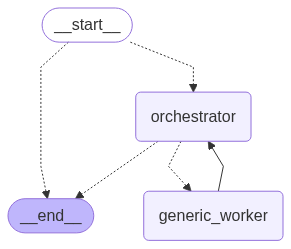

In [4]:
display(Image(app.get_graph().draw_mermaid_png()))
